# Lab 3: Extending Logistic Regression

In [298]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as SKLLogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from numpy.linalg import pinv
from numpy import ma
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
import copy
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
pd.set_option('display.max_columns', None)

# Business Understanding

The Bundesliga is the top professional soccer league in Germany. Just like many other major sports leagues, a significant amount of money is bet on games each season. According to [Statista](https://www.statista.com/statistics/1263462/value-betting-on-european-soccer/), 32.4 billion euros were bet on Bundesliga games in the 2020/21 season. Thus, it is very important for sports betters to be able to predict whether each game will result in a win, loss, or draw for each team. Rather than predicting the result for both teams in a game, we will create a model that predicts the result only for the home team in this notebook, as the away team's result is implied based on the home team's result. An accurate prediction algorithm has the potential to win a sports better a lot of money, but an inaccurate prediction algorithm could also lose a better a lot of money. As games are only played weekly, a model would only need to be trained once per week. This means that a prediction model would be mostly used for offline analysis. According to [Leans.ai](https://leans.ai/sports/sports-bets-must-win-to-profit/#:~:text=The%20percentage%20of%20sports%20bets,profit%20over%20the%20long%20term.), a better needs to win approximately 52.4% of the time to make a profit. Thus, a prediction algorithm needs to be correct a minimum of 52.4% of the time to be useful.

Dataset Link: https://www.kaggle.com/datasets/oles04/bundesliga-seasons

# Cleaning Data

In [309]:
df_init = pd.read_csv("../Datasets/bulidata.csv")

print(len(df_init))
df_init.head()

5508


,Unnamed: 0,MATCH_DATE,LEAGUE_NAME,SEASON,LEAGUE,FINISHED,LOCATION,VIEWER,MATCHDAY,MATCHDAY_NR,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM,HOME_ICON,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM,AWAY_ICON,GOALS_HOME,GOALS_AWAY,DRAW,WIN_HOME,WIN_AWAY
0,0,2005-08-05 20:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,München,NaN,1. Spieltag,1,40,FC Bayern München,Bayern,https://i.imgur.com/jJEsJrj.png,87,Borussia Mönchengladbach,Gladbach,https://i.imgur.com/KSIk0Eu.png,3,0,0.0,1.0,0.0
1,1,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Köln,NaN,1. Spieltag,1,65,1. FC Köln,Köln,https://upload.wikimedia.org/wikipedia/en/thum...,81,1. FSV Mainz 05,Mainz,https://upload.wikimedia.org/wikipedia/commons...,1,0,0.0,1.0,0.0
2,2,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Duisburg,NaN,1. Spieltag,1,107,MSV Duisburg,Duisburg,https://upload.wikimedia.org/wikipedia/en/c/c8...,16,VfB Stuttgart,Stuttgart,https://i.imgur.com/v0tkpNx.png,1,1,1.0,0.0,0.0
3,3,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Hamburg,NaN,1. Spieltag,1,100,Hamburger SV,HSV,https://upload.wikimedia.org/wikipedia/commons...,79,1. FC Nürnberg,Nürnberg,https://upload.wikimedia.org/wikipedia/commons...,3,0,0.0,1.0,0.0
4,4,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Wolfsburg,NaN,1. Spieltag,1,131,VfL Wolfsburg,Wolfsburg,https://i.imgur.com/ucqKV4B.png,7,Borussia Dortmund,BVB,https://upload.wikimedia.org/wikipedia/commons...,2,2,1.0,0.0,0.0


This data set provides summary information about every Bundesliga game since the beginning of the 2005/06 season (5,508 games). The data as provided is not very useful for creating a prediction algorithm, so it will need to be restructured to suit our purposes. We can start by removing all of the unnecessary columns and renaming the remaining columns to more user-friendly names.

In [3]:
df_init = df_init.drop([
    "Unnamed: 0", "MATCH_DATE", "LEAGUE", "LEAGUE_NAME", "FINISHED", "LOCATION", "VIEWER", "MATCHDAY",
    "HOME_TEAM_NAME", "HOME_TEAM", "HOME_ICON", "AWAY_TEAM_NAME", "AWAY_TEAM", "AWAY_ICON"
], axis = 1).rename(columns = {
    "SEASON": "season",
    "MATCHDAY_NR": "matchday",
    "HOME_TEAM_ID": "home_team",
    "AWAY_TEAM_ID": "away_team",
    "GOALS_HOME": "home_goals",
    "GOALS_AWAY": "away_goals",
    "DRAW": "draw",
    "WIN_HOME": "home_win",
    "WIN_AWAY": "home_loss"
})
df_init[["home_team", "away_team"]] = df_init[["home_team", "away_team"]].astype(str)

df_init.head()

,season,matchday,home_team,away_team,home_goals,away_goals,draw,home_win,home_loss
0,2005,1,40,87,3,0,0.0,1.0,0.0
1,2005,1,65,81,1,0,0.0,1.0,0.0
2,2005,1,107,16,1,1,1.0,0.0,0.0
3,2005,1,100,79,3,0,0.0,1.0,0.0
4,2005,1,131,7,2,2,1.0,0.0,0.0


Since we want data on teams home and away, we can split the data into a data frame for the home teams and a data frame for the away teams. These data frames can be merged back together with more generic column names so that we now have 2 records for each game.

In [4]:
df_home = df_init.copy().rename(columns = {
    "home_team": "team",
    "away_team": "opponent",
    "home_goals": "scored",
    "away_goals": "conceded",
    "home_win": "win",
    "home_loss": "loss"
})
df_away = df_init.copy().rename(columns = {
    "home_team": "opponent",
    "away_team": "team",
    "home_goals": "conceded",
    "away_goals": "scored",
    "home_win": "loss",
    "home_loss": "win"
})
df_home["home"] = "1"
df_away["home"] = "0"
df_all = pd.concat([df_home, df_away])
df_all = df_all.sort_values(["season", "matchday"])

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home
0,2005,1,40,87,3,0,0.0,1.0,0.0,1
1,2005,1,65,81,1,0,0.0,1.0,0.0,1
2,2005,1,107,16,1,1,1.0,0.0,0.0,1
3,2005,1,100,79,3,0,0.0,1.0,0.0,1
4,2005,1,131,7,2,2,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0


We can now calculate rolling sums of goals scored, goals conceded, wins, draws, and losses for each team in each season. Most soccer leagues use the last 5 games to represent a team's current form, so we will use 5 game rolling sums. This means that we will no longer have useable data on the first 5 games of each season, but there are not many useful predictors in this data set anyway and we have a large number of records, so this is an acceptable loss. We can also calculate the points a team got from a game (3 points for a win, 1 point for a draw, and 0 points for a loss) and how many points each team has gotten that season prior to a given game. Finally, we can calculate the same values for a team's upcoming opponents over the last 5 games and the difference between the teams' seasonal points totals.

In [5]:
df_all["scored_5"] = df_all.groupby(["season", "team"])["scored"].transform(lambda x: x.rolling(5).sum().shift())
df_all["conceded_5"] = df_all.groupby(["season", "team"])["conceded"].transform(lambda x: x.rolling(5).sum().shift())
df_all["win_5"] = df_all.groupby(["season", "team"])["win"].transform(lambda x: x.rolling(5).sum().shift())
df_all["draw_5"] = df_all.groupby(["season", "team"])["draw"].transform(lambda x: x.rolling(5).sum().shift())
df_all["loss_5"] = df_all.groupby(["season", "team"])["loss"].transform(lambda x: x.rolling(5).sum().shift())
df_all["game_pts"] = df_all["win"] * 3 + df_all["draw"]
df_all["pts"] = df_all.groupby(["season", "team"])["game_pts"].cumsum().sub(df_all["game_pts"])

df_all["opp_scored_5"] = df_all.groupby(["season", "opponent"])["scored"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_conceded_5"] = df_all.groupby(["season", "opponent"])["conceded"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_win_5"] = df_all.groupby(["season", "opponent"])["win"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_draw_5"] = df_all.groupby(["season", "opponent"])["draw"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_loss_5"] = df_all.groupby(["season", "opponent"])["loss"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_game_pts"] = df_all["loss"] * 3 + df_all["draw"]
df_all["opp_pts"] = df_all.groupby(["season", "team"])["opp_game_pts"].cumsum().sub(df_all["opp_game_pts"])
df_all["pts_diff"] = df_all["pts"] - df_all["opp_pts"]

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home,scored_5,conceded_5,win_5,draw_5,loss_5,game_pts,pts,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,opp_game_pts,opp_pts,pts_diff
0,2005,1,40,87,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2005,1,65,81,1,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2005,1,107,16,1,1,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,2005,1,100,79,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2005,1,131,7,2,2,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0,12.0,7.0,3.0,0.0,2.0,3.0,68.0,6.0,11.0,1.0,1.0,3.0,0.0,23.0,45.0
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0,7.0,15.0,2.0,1.0,2.0,0.0,31.0,4.0,7.0,1.0,0.0,4.0,3.0,58.0,-27.0
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0,9.0,9.0,2.0,0.0,3.0,1.0,35.0,6.0,9.0,1.0,2.0,2.0,1.0,59.0,-24.0
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0,8.0,9.0,1.0,1.0,3.0,0.0,36.0,7.0,7.0,2.0,1.0,2.0,3.0,57.0,-21.0


The original dataset has one-hot encoded the result of the game, but we want a single column with the result.

In [311]:
results = []
for row in df_all.itertuples():
    if row.draw == 1:
        results.append("Draw")
    elif row.win == 1:
        results.append("Win")
    else:
        results.append("Loss")
df_all["result"] = results

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home,scored_5,conceded_5,win_5,draw_5,loss_5,game_pts,pts,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,opp_game_pts,opp_pts,pts_diff,result
0,2005,1,40,87,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
1,2005,1,65,81,1,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
2,2005,1,107,16,1,1,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Draw
3,2005,1,100,79,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
4,2005,1,131,7,2,2,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0,12.0,7.0,3.0,0.0,2.0,3.0,68.0,6.0,11.0,1.0,1.0,3.0,0.0,23.0,45.0,Win
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0,7.0,15.0,2.0,1.0,2.0,0.0,31.0,4.0,7.0,1.0,0.0,4.0,3.0,58.0,-27.0,Loss
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0,9.0,9.0,2.0,0.0,3.0,1.0,35.0,6.0,9.0,1.0,2.0,2.0,1.0,59.0,-24.0,Draw
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0,8.0,9.0,1.0,1.0,3.0,0.0,36.0,7.0,7.0,2.0,1.0,2.0,3.0,57.0,-21.0,Loss


Now that we have calculated all of the statistics we want for our prediction model, we can remove all columns that are not going to be used in the model, filter the data for only home games that we will use for prediction, and convert all columns but the result to integers.

In [7]:
df = df_all[df_all["home"] == "1"].dropna().reset_index(drop = True).drop([
    "season", "matchday", "team", "opponent", "scored", "conceded", "draw", "win", "loss", 
    "home", "game_pts", "pts", "opp_game_pts", "opp_pts"
], axis = 1)
df.loc[:, df.columns != "result"] = df.loc[:, df.columns != "result"].astype(int)

df 

,scored_5,conceded_5,win_5,draw_5,loss_5,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,pts_diff,result
0,5,8,1,2,2,6,16,0,1,4,-3,Win
1,8,9,1,2,2,8,5,2,2,1,-3,Win
2,3,9,1,1,3,3,14,0,0,5,-6,Loss
3,6,5,1,3,1,8,6,1,3,1,0,Loss
4,11,10,2,1,2,8,9,2,0,3,0,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
4693,11,6,3,1,1,7,12,2,0,3,-3,Loss
4694,7,4,4,0,1,15,7,2,1,2,33,Win
4695,9,6,2,2,1,9,9,3,0,2,-24,Draw
4696,7,7,2,1,2,9,8,3,1,1,27,Win


# Data Understanding

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   scored_5        4698 non-null   int64 
 1   conceded_5      4698 non-null   int64 
 2   win_5           4698 non-null   int64 
 3   draw_5          4698 non-null   int64 
 4   loss_5          4698 non-null   int64 
 5   opp_scored_5    4698 non-null   int64 
 6   opp_conceded_5  4698 non-null   int64 
 7   opp_win_5       4698 non-null   int64 
 8   opp_draw_5      4698 non-null   int64 
 9   opp_loss_5      4698 non-null   int64 
 10  pts_diff        4698 non-null   int64 
 11  result          4698 non-null   object
dtypes: int64(11), object(1)
memory usage: 440.6+ KB


Only keeping the records for the home team and dropping the first 5 records for each season results in a total of 4,698 games to train our model with. There are no missing values in this data set. All columns are numeric except for the result.

In [312]:
# Allow text to wrap to avoid cutting off descriptions
pd.set_option('display.max_colwidth', 0)

# Create data frame with feature descriptions
pd.DataFrame({
    "Feature": df.columns,
    "Description": [
        "How many goals the home team has scored over their last 5 games",
        "How many goals the home team has conceded over their last 5 games",
        "How many games the home team has won over their last 5 games",
        "How many games the home team has drawn over their last 5 games",
        "How many games the home team has lost over their last 5 games",
        "How many goals the away team has scored over their last 5 games",
        "How many goals the away team has conceded over their last 5 games",
        "How many games the away team has won over their last 5 games",
        "How many games the away team has drawn over their last 5 games",
        "How many games the away team has lost over their last 5 games",
        "The difference in total points this season for the 2 teams",
        "The result of the game for the home team"
    ],
    "Scale": [
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Interval",
        "Ordinal"
    ],
    "Discrete/Continuous": [
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete"
    ],
    "Range": [
        "{} - {}".format(min(df["scored_5"]), max(df["scored_5"])),
        "{} - {}".format(min(df["conceded_5"]), max(df["conceded_5"])),
        "{} - {}".format(min(df["win_5"]), max(df["win_5"])),
        "{} - {}".format(min(df["draw_5"]), max(df["draw_5"])),
        "{} - {}".format(min(df["loss_5"]), max(df["loss_5"])),
        "{} - {}".format(min(df["opp_scored_5"]), max(df["opp_scored_5"])),
        "{} - {}".format(min(df["opp_conceded_5"]), max(df["opp_conceded_5"])),
        "{} - {}".format(min(df["opp_win_5"]), max(df["opp_win_5"])),
        "{} - {}".format(min(df["opp_draw_5"]), max(df["opp_draw_5"])),
        "{} - {}".format(min(df["opp_loss_5"]), max(df["opp_loss_5"])),
        "{} - {}".format(min(df["pts_diff"]), max(df["pts_diff"])),
        repr(set(df["result"]))
    ]
})

,Feature,Description,Scale,Discrete/Continuous,Range
0,scored_5,How many goals the home team has scored over their last 5 games,Ratio,Discrete,0 - 25
1,conceded_5,How many goals the home team has conceded over their last 5 games,Ratio,Discrete,0 - 22
2,win_5,How many games the home team has won over their last 5 games,Ratio,Discrete,0 - 5
3,draw_5,How many games the home team has drawn over their last 5 games,Ratio,Discrete,0 - 5
4,loss_5,How many games the home team has lost over their last 5 games,Ratio,Discrete,0 - 5
5,opp_scored_5,How many goals the away team has scored over their last 5 games,Ratio,Discrete,0 - 19
6,opp_conceded_5,How many goals the away team has conceded over their last 5 games,Ratio,Discrete,0 - 23
7,opp_win_5,How many games the away team has won over their last 5 games,Ratio,Discrete,0 - 5
8,opp_draw_5,How many games the away team has drawn over their last 5 games,Ratio,Discrete,0 - 5
9,opp_loss_5,How many games the away team has lost over their last 5 games,Ratio,Discrete,0 - 5


In [9]:
df.describe()

,scored_5,conceded_5,win_5,draw_5,loss_5,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,pts_diff
count,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000,4698.000000
mean,5.985951,6.200085,1.714985,1.471052,1.813963,5.998936,6.213069,1.718178,1.464666,1.817156,-0.272669
std,3.465548,3.327101,1.166687,1.068902,1.147927,3.273398,3.586271,1.141926,1.073480,1.196647,16.771135
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-63.000000
25%,3.000000,4.000000,1.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,-12.000000
50%,6.000000,6.000000,2.000000,1.000000,2.000000,6.000000,6.000000,2.000000,1.000000,2.000000,0.000000
75%,8.000000,8.000000,2.000000,2.000000,3.000000,8.000000,8.000000,2.000000,2.000000,3.000000,9.000000
max,25.000000,22.000000,5.000000,5.000000,5.000000,19.000000,23.000000,5.000000,5.000000,5.000000,78.000000


In [10]:
pd.Series.value_counts(df["result"]) / len(df)

Win     0.427842
Draw    0.287569
Loss    0.284589
Name: result, dtype: float64

There is a slight class imbalance here, as 43% of games result in a win for the home team, 29% result in a draw, and 28% result in a loss for the home team.

# Modeling

## Logistic Regression Implementation

In [225]:
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, regularization = "none", mixture = None, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg = regularization
        self.mix = mixture
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return gradient
    
    # Calculate the L1 term (lasso)
    def _get_L1(self, weights = True):
        if weights:
            return self.C * np.sign(self.w_[1:])
        else:
            return self.C
    
    # Calculate the L2 term (ridge)
    def _get_L2(self, weights):
        if weights:
            return -2 * self.w_[1:] * self.C
        else:
            return -2 * self.C
    
    # Get the regularization (if any)
    def _get_regularization(self, weights = True):
        
        if self.reg == "l1":
            return self._get_L1(weights = weights)
        elif self.reg == "l2":
            return self._get_L2(weights = weights)
        elif self.reg == "both":
            return (((1 - self.mix) * self._get_L2(weights = weights)) + (self.mix * self._get_L1(weights = weights)))
        else:
            return 0
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
       
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

In [226]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return gradient

In [227]:
class HessianLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X # calculate the hessian
        hessian += self._get_regularization(weights = False)
        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return pinv(hessian) @ gradient

In [228]:
class MyLogisticRegression:
    def __init__(self, eta, iterations=20, solver="steepest", regularization="none", mixture=0.5, C=0.001):
        assert solver in ["steepest", "stochastic", "newton"], "Invalid solver input"
        assert regularization in ["none", "l1", "l2", "both"], "Invalid regularization input"
        assert mixture >= 0 and mixture <= 1, "Invalid mixture"
        
        self.eta = eta
        self.iters = iterations
        self.opt = solver
        self.reg = regularization
        self.mix = mixture
        self.C = C
        
    def __str__(self):
        if(hasattr(self,'w_')):
            # is we have trained the object
            return 'Multiclass Logistic Regression Object with {} solver and {} regularization and coefficients:\n'.format(self.opt, self.reg) + str(self.w_) 
        else:
            return 'Untrained Multiclass Logistic Regression Object with {} solver and {} regularization'.format(self.opt, self.reg)
     
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        # Parameters to pass into binary classifier
        params = {
            "eta": self.eta,
            "iterations": self.iters,
            "regularization": self.reg,
            "mixture": self.mix,
            "C": self.C
        }
        # Set solver based on specified optimization method
        if self.opt == "steepest":
            self.solver = BinaryLogisticRegression
        elif self.opt == "stochastic":
            self.solver = StochasticLogisticRegression
        else:
            self.solver = HessianLogisticRegression
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solver(**params)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    # Set specified hyperparameters after tuning (or manually)
    def set_hyperparameters(self, params):
        # Set parameters with defined hyperparameters
        if params["solver"] != None:
            assert params["solver"] in ["steepest", "stochastic", "newton"], "Invalid solver input"
            self.opt = params["solver"]
        
        if params["regularization"] != None:
            assert params["regularization"] in ["none", "l1", "l2", "both"], "Invalid regularization input"
            self.reg = params["regularization"]
            
        if params["mixture"] != None:
            assert params["mixture"] >= 0 and params["mixture"] <= 1, "Invalid mixture"
            self.mix = params["mixture"]
            
        if params["penalty"] != None:
            self.C = params["penalty"]

## Model Fitting

### My Implementation

In [229]:
# Create a hyperparameter grid for solver, regularization, mixture, and C
def create_grid(
    combinations=100, seed = None, 
    solver = None, regularization = None, mixture = None, C = None
):
    # Set random seed if defined
    if seed != None:
        random.seed(seed)

    # Create data frame for grid
    grid = pd.DataFrame()

    # Create ranges of values
    opt = ["steepest", "stochastic", "newton"]
    reg = ["none", "l1", "l2", "both"]
    mix = np.linspace(0, 1, 1000)
    pen = np.logspace(-5, 1, 20)

    # Randomly sample values
    if solver == None:
        grid["solver"] = random.choices(opt, k = combinations)
    else:
        grid["solver"] = [solver] * combinations

    if regularization == None:
        grid["regularization"] = random.choices(reg, k = combinations)
    else:
        grid["regularization"] = [regularization] * combinations

    if mixture == None:
        grid["mixture"] = random.choices(mix, k = combinations)
    else:
        grid["mixture"] = [mixture] * combinations

    if C == None:
        grid["penalty"] = random.choices(pen, k = combinations)
    else:
        grid["penalty"] = [C] * combinations

    return grid

In [291]:
# Tune a grid of hyperparameters
def tune(X, y, cv_object, grid, params, LogisticClass = MyLogisticRegression):
    # Create a deep copy of the grid so that the original is not modified
    grid = copy.deepcopy(grid)
    # Lists to store accuracy and time of each combination
    acc = []
    times = []
    # Iterate through each combination in the grid
    for row in grid.itertuples():
        curr_acc = []
        curr_times = []
        # Iterate through each train/test split in cv_object
        for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
            # Extract hyperparameters
            params["solver"] = row.solver
            params["regularization"] = row.regularization
            params["mixture"] = row.mixture
            params["C"] = row.penalty

            # Fit model with these hyperparameters and calculate the accuracy
            model = LogisticClass(**params)
            start = time.time()
            model.fit(X[train_indices], y[train_indices])
            curr_times.append(time.time() - start)
            yhat = model.predict(X[test_indices])
            curr_acc.append(accuracy_score(y[test_indices], yhat))
            
        # Add the mean accuracy and time from all of the train/test splits to acc
        acc.append(np.mean(curr_acc))
        times.append(np.mean(curr_times))

    # Add accuracy and time column to grid
    grid["accuracy"] = acc
    grid["time"] = times
    # Sort grid by accuracy
    grid = grid.sort_values(["accuracy", "time"], ascending = [False, True])
    # Return grid
    return grid

In [292]:
cv_object = ShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 7324)
scaler = StandardScaler()

X = df.loc[:, df.columns != "result"].to_numpy()
X = scaler.fit_transform(X)
y = df["result"].to_numpy()

In [293]:
my_model = MyLogisticRegression(0.1)
print(my_model)

Untrained Multiclass Logistic Regression Object with steepest solver and none regularization


In [294]:
grid_init = create_grid(200, seed = 7324)
grid_init

,solver,regularization,mixture,penalty
0,newton,both,0.163163,0.000183
1,stochastic,both,0.374374,0.014384
2,newton,l2,0.188188,0.000089
3,steepest,both,0.259259,0.000021
4,newton,l2,0.063063,0.014384
...,...,...,...,...
195,newton,none,0.832833,0.000089
196,newton,none,0.492492,0.263665
197,steepest,both,0.210210,0.029764
198,stochastic,l2,0.000000,0.029764


In [295]:
%%time

params = {
    "eta": 0.1,
    "iterations": 20
}

grid_acc = tune(X, y, cv_object, grid_init, params)
grid_acc

CPU times: user 23min 13s, sys: 6min 31s, total: 29min 45s
Wall time: 2min 35s


,solver,regularization,mixture,penalty,accuracy,time
197,steepest,both,0.210210,0.029764,0.475000,0.018275
32,steepest,both,0.068068,0.061585,0.473936,0.010576
86,steepest,both,0.751752,0.000785,0.473936,0.010876
50,steepest,both,0.347347,0.001624,0.473936,0.012600
61,steepest,both,0.400400,0.001624,0.473404,0.012046
...,...,...,...,...,...,...
177,stochastic,both,0.744745,0.545559,0.313830,0.003371
31,stochastic,l1,0.607608,4.832930,0.313298,0.001958
52,stochastic,l1,0.474474,4.832930,0.309574,0.002716
63,stochastic,l1,0.074074,0.545559,0.305851,0.001652


In [296]:
grid_acc.groupby(["solver", "regularization"])[["accuracy", "time"]].describe()

accuracy                                    \
                             count      mean           std       min   
solver     regularization                                              
newton     both               20.0  0.454840  3.695420e-02  0.297872   
           l1                 13.0  0.462807  1.475266e-04  0.462766   
           l2                 19.0  0.462822  1.677137e-04  0.462766   
           none               16.0  0.462766  1.146633e-16  0.462766   
steepest   both               21.0  0.465552  1.263329e-02  0.438830   
           l1                 13.0  0.462316  1.399898e-02  0.439894   
           l2                 13.0  0.472136  4.084828e-04  0.471277   
           none               18.0  0.472340  1.142410e-16  0.472340   
stochastic both               24.0  0.377305  2.952994e-02  0.313830   
           l1                 14.0  0.367667  4.045146e-02  0.305851   
           l2                 17.0  0.398248  2.477959e-02  0.355319   
           none               12.0  0.390027  2.656103e-02  0.352660   

                                                                   time  \
                                25%       50%       75%       max count   
solver     regularization                                                 
newton     both            0.462766  0.462766  0.462899  0.465957  20.0   
           l1              0.462766  0.462766  0.462766  0.463298  13.0   
           l2              0.462766  0.462766  0.462766  0.463298  19.0   
           none            0.462766  0.462766  0.462766  0.462766  16.0   
steepest   both            0.461170  0.472340  0.472872  0.475000  21.0   
           l1              0.450532  0.471809  0.472340  0.473404  13.0   
           l2              0.472340  0.472340  0.472340  0.472340  13.0   
           none            0.472340  0.472340  0.472340  0.472340  18.0   
stochastic both            0.358644  0.379787  0.394814  0.423404  24.0   
           l1              0.348138  0.372606  0.390027  0.436702  14.0   
           l2              0.377128  0.404787  0.419149  0.435638  17.0   
           none            0.364096  0.386968  0.415293  0.420745  12.0   

                                                                             \
                               mean       std       min       25%       50%   
solver     regularization                                                     
newton     both            1.134833  0.127838  1.007546  1.052838  1.088415   
           l1              1.104117  0.132372  0.974854  1.025461  1.056211   
           l2              1.119636  0.097425  0.986520  1.055762  1.100454   
           none            1.151495  0.157665  1.004660  1.047627  1.083715   
steepest   both            0.012053  0.002757  0.007514  0.010182  0.011708   
           l1              0.011718  0.003958  0.007044  0.008868  0.010716   
           l2              0.011227  0.002266  0.007794  0.010205  0.011537   
           none            0.012220  0.003870  0.006971  0.011104  0.011426   
stochastic both            0.002093  0.000815  0.001376  0.001511  0.001545   
           l1              0.001993  0.001270  0.001217  0.001347  0.001381   
           l2              0.001486  0.000466  0.001253  0.001322  0.001396   
           none            0.001688  0.000721  0.001160  0.001193  0.001295   

                                               
                                75%       max  
solver     regularization                      
newton     both            1.189477  1.441755  
           l1              1.123951  1.454071  
           l2              1.151398  1.332840  
           none            1.190118  1.528009  
steepest   both            0.013529  0.018275  
           l1              0.013808  0.021831  
           l2              0.013300  0.014937  
           none            0.012029  0.025750  
stochastic both            0.002592  0.003784  
           l1              0.002128  0.005999  
         

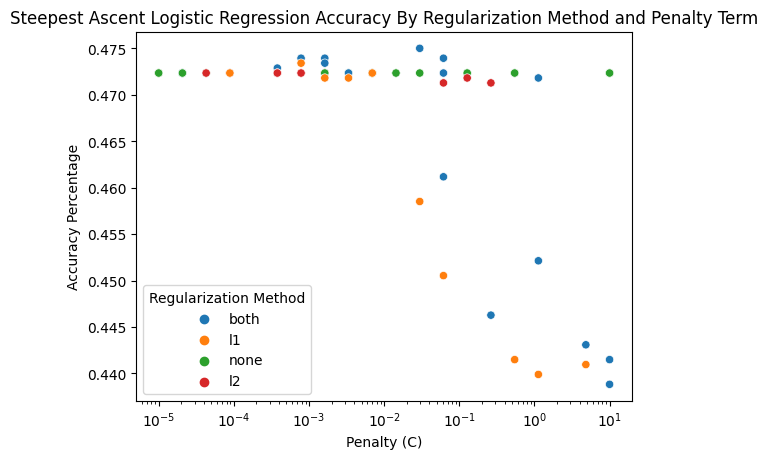

In [304]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "steepest"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Steepest Ascent Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

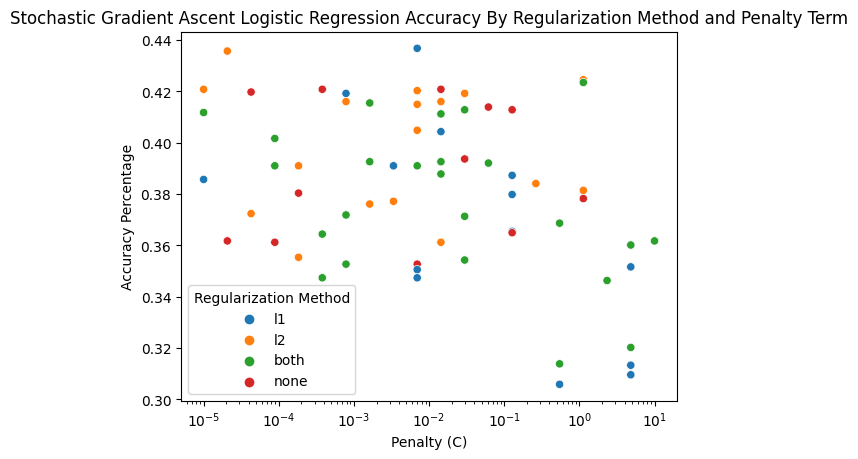

In [305]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "stochastic"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Stochastic Gradient Ascent Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

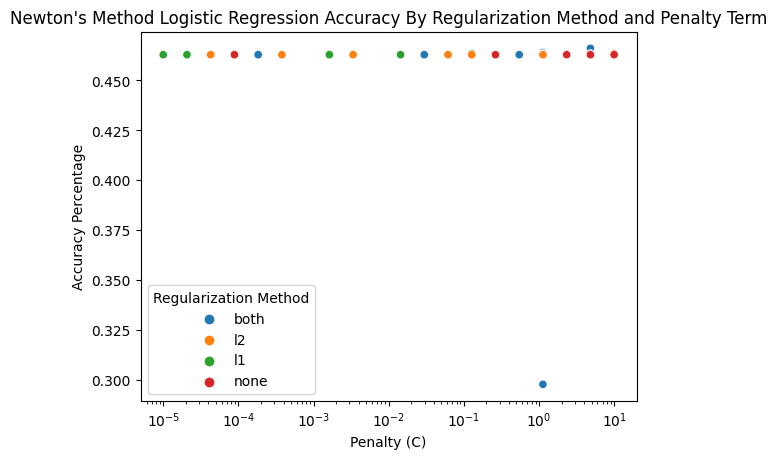

In [306]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "newton"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Newton's Method Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

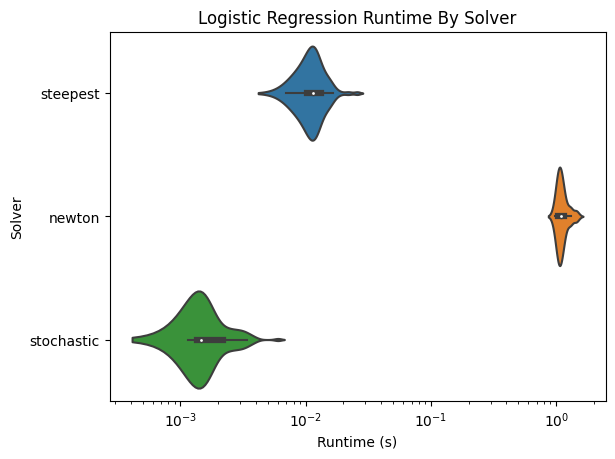

In [308]:
sns.violinplot(
    data = grid_acc,
    x = "time",
    y = "solver",
    scale = "count"
)

plt.title("Logistic Regression Runtime By Solver")
plt.xlabel("Runtime (s)")
plt.ylabel("Solver")
plt.xscale("log")

plt.show()

In [237]:
hyperparams = grid_acc.to_dict("records")[0]
cv_object = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 7324)

In [238]:
%%time

my_acc = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    my_model = MyLogisticRegression(0.1)
    my_model.set_hyperparameters(hyperparams)
    my_model.fit(X[train_indices], y[train_indices])
    yhat = my_model.predict(X[test_indices])
    my_acc.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(my_acc))

Accuracy of:  0.4523404255319149
CPU times: user 1.03 s, sys: 1.29 s, total: 2.32 s
Wall time: 205 ms


In [239]:
print(my_model)

conf_mat

Multiclass Logistic Regression Object with steepest solver and both regularization and coefficients:
[[-0.3432467  -0.06048979 -0.0356484  -0.02616882  0.03832369 -0.02145753
  -0.05656724 -0.06098486 -0.01058123  0.02632831 -0.02557068 -0.04674137]
 [-0.34071103 -0.04755537  0.03973387 -0.05151315  0.01160245  0.05197809
  -0.03468777  0.09127355 -0.04415784 -0.03021807  0.05954303 -0.08940412]
 [-0.11294418  0.10242974 -0.01155209  0.07286895 -0.04513832 -0.0424557
   0.08325956 -0.04270667  0.05052951 -0.00851964 -0.05132189  0.12313364]]


array([[ 59,  78, 145],
       [ 50,  87, 122],
       [ 71,  78, 250]])

### Scikit-Learn Implementation

In [240]:
skl_model = SKLLogisticRegression(solver='liblinear',n_jobs=1, 
                           multi_class='ovr', C = 1/0.001, 
                           penalty='l1',max_iter=100) 
print(skl_model)

LogisticRegression(C=1000.0, multi_class='ovr', n_jobs=1, penalty='l1',
                   solver='liblinear')


In [241]:
%%time

skl_acc = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    skl_model.fit(X[train_indices], y[train_indices])
    yhat = skl_model.predict(X[test_indices])
    skl_acc.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(skl_acc))

Accuracy of:  0.4581914893617022
CPU times: user 479 ms, sys: 2.21 s, total: 2.69 s
Wall time: 235 ms


In [242]:
print(skl_model.coef_)

conf_mat

[[-0.24366883  0.09852482  0.14317169  0.06813298 -0.12008123 -0.1449484
  -0.12965254  0.02101223  0.00539564 -0.00918487 -0.14570284]
 [-0.13853288  0.02555198 -0.01422884 -0.0037845   0.00485151 -0.27015311
   0.48548872  0.12822441  0.00267363 -0.09509666 -0.26897286]
 [ 0.30609515 -0.09005623 -0.07851665 -0.02778008  0.1160135   0.36702085
  -0.34136182 -0.10286749  0.02769128  0.1372531   0.34397746]]


array([[ 44,  59, 179],
       [ 33,  82, 144],
       [ 57,  52, 290]])

## Deployment

# MSE Objective Function

## Newton's Method Implementation

In [279]:
class HessianMSELogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        num_samples, num_features = X.shape
        # Compute sigmoid derivative
        g = self.predict_proba(X, add_bias = False).ravel()
        g_prime = g * (1 - g)
        # Compute hessian
        hessian = (X.T @ np.diag(g_prime * (1 - g_prime)) @ X) / num_samples
        hessian += self._get_regularization(weights = False)
        # Compute gradient
        ydiff = y - g
        gradient = np.sum(X * 2 * ydiff[:,np.newaxis] * g_prime.reshape((len(g_prime), 1)), axis = 0) / num_samples
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return pinv(hessian) @ gradient

In [280]:
class MyLogisticRegression2:
    def __init__(self, eta, iterations=20, solver="steepest", regularization="none", mixture=0.5, C=0.001):
        assert solver in ["steepest", "stochastic", "newton", "newton-mse"], "Invalid solver input"
        assert regularization in ["none", "l1", "l2", "both"], "Invalid regularization input"
        assert mixture >= 0 and mixture <= 1, "Invalid mixture"
        
        self.eta = eta
        self.iters = iterations
        self.opt = solver
        self.reg = regularization
        self.mix = mixture
        self.C = C
        
    def __str__(self):
        if(hasattr(self,'w_')):
            # is we have trained the object
            return 'Multiclass Logistic Regression Object with {} solver and {} regularization and coefficients:\n'.format(self.opt, self.reg) + str(self.w_) 
        else:
            return 'Untrained Multiclass Logistic Regression Object with {} solver and {} regularization'.format(self.opt, self.reg)
     
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        # Parameters to pass into binary classifier
        params = {
            "eta": self.eta,
            "iterations": self.iters,
            "regularization": self.reg,
            "mixture": self.mix,
            "C": self.C
        }
        # Set solver based on specified optimization method
        if self.opt == "steepest":
            self.solver = BinaryLogisticRegression
        elif self.opt == "stochastic":
            self.solver = StochasticLogisticRegression
        elif self.opt == "newton":
            self.solver = HessianLogisticRegression
        else:
            self.solver = HessianMSELogisticRegression
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solver(**params)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    # Set specified hyperparameters after tuning (or manually)
    def set_hyperparameters(self, params):
        # Set parameters with defined hyperparameters
        if params["solver"] != None:
            assert params["solver"] in ["steepest", "stochastic", "newton", "newton-mse"], "Invalid solver input"
            self.opt = params["solver"]
        
        if params["regularization"] != None:
            assert params["regularization"] in ["none", "l1", "l2", "both"], "Invalid regularization input"
            self.reg = params["regularization"]
            
        if params["mixture"] != None:
            assert params["mixture"] >= 0 and params["mixture"] <= 1, "Invalid mixture"
            self.mix = params["mixture"]
            
        if params["penalty"] != None:
            self.C = params["penalty"]

## Fit Model

In [283]:
cv_object = ShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 7324)
grid_init2 = create_grid(50, seed = 7324, solver = "newton-mse")
grid_init2

,solver,regularization,mixture,penalty
0,newton-mse,both,0.316316,2.335721
1,newton-mse,l2,0.289289,0.000043
2,newton-mse,both,0.421421,0.000021
3,newton-mse,l1,0.520521,0.127427
4,newton-mse,l2,0.060060,0.263665
5,newton-mse,l2,0.194194,0.000379
6,newton-mse,both,0.305305,10.000000
7,newton-mse,both,0.918919,0.545559
8,newton-mse,l2,0.576577,0.000785
9,newton-mse,l2,0.696697,0.263665


In [284]:
%%time

params = {
    "eta": 0.1,
    "iterations": 20
}

grid_acc2 = tune(X, y, cv_object, grid_init2, params, MyLogisticRegression2)
grid_acc2

CPU times: user 15min 44s, sys: 4min 42s, total: 20min 26s
Wall time: 1min 45s


,solver,regularization,mixture,penalty,accuracy,time
10,newton-mse,l1,0.732733,0.000785,0.469681,0.995733
41,newton-mse,both,0.800801,0.001624,0.469149,0.987960
20,newton-mse,l2,0.256256,0.014384,0.466489,1.029491
37,newton-mse,l2,0.610611,0.014384,0.466489,1.033696
26,newton-mse,l2,0.638639,0.061585,0.463830,0.985558
12,newton-mse,both,0.843844,0.000183,0.463830,1.248263
38,newton-mse,l2,0.027027,0.000010,0.463298,0.983961
49,newton-mse,both,0.954955,0.006952,0.463298,0.994163
42,newton-mse,l2,0.990991,0.000785,0.463298,1.010139
8,newton-mse,l2,0.576577,0.000785,0.463298,1.010346


In [285]:
grid_acc2.groupby(["solver", "regularization"])[["accuracy", "time"]].describe()

accuracy                                    \
                             count      mean           std       min   
solver     regularization                                              
newton-mse both               11.0  0.435638  5.067561e-02  0.320213   
           l1                 18.0  0.392258  4.959265e-02  0.345745   
           l2                 13.0  0.403069  8.137549e-02  0.291489   
           none                8.0  0.462766  5.934392e-17  0.462766   

                                                                   time  \
                                25%       50%       75%       max count   
solver     regularization                                                 
newton-mse both            0.426064  0.462766  0.463298  0.469149  11.0   
           l1              0.350266  0.364362  0.447074  0.469681  18.0   
           l2              0.300532  0.463298  0.463298  0.466489  13.0   
           none            0.462766  0.462766  0.462766  0.462766   8.0   

                                                                             \
                               mean       std       min       25%       50%   
solver     regularization                                                     
newton-mse both            1.032948  0.078656  0.978950  0.990724  1.009095   
           l1              1.066935  0.124365  0.977278  0.992523  0.998165   
           l2              1.060548  0.127251  0.983961  0.987767  1.010346   
           none            1.046425  0.098520  0.979214  1.001301  1.017782   

                                               
                                75%       max  
solver     regularization                      
newton-mse both            1.027933  1.248263  
           l1              1.082104  1.334311  
           l2              1.033696  1.375971  
           none            1.031473  1.285426

In [286]:
cv_object = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 7324)
hyperparams = grid_acc2.to_dict("records")[0]

Untrained Multiclass Logistic Regression Object with newton-mse solver and l1 regularization


In [287]:
%%time

my_acc2 = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    my_model2 = MyLogisticRegression2(0.1)
    my_model2.set_hyperparameters(hyperparams)
    my_model2.fit(X[train_indices], y[train_indices])
    yhat = my_model2.predict(X[test_indices])
    my_acc2.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(my_acc2))

Accuracy of:  0.4593617021276596
CPU times: user 1min 33s, sys: 25.8 s, total: 1min 59s
Wall time: 10.3 s


In [288]:
print(my_model2)

conf_mat

Multiclass Logistic Regression Object with newton-mse solver and l1 regularization and coefficients:
[[-0.65370306 -0.1734712   0.08070484  0.5953325   0.485042    0.38686543
  -0.09801952 -0.09230121  0.50033041  0.45721271  0.50888004 -0.09687296]
 [-0.65079039 -0.1125054   0.03737117  0.47687458  0.41431531  0.43740512
  -0.20390482  0.3360938   0.54169538  0.41082711  0.3797333  -0.16711517]
 [-0.21205135  0.25304552 -0.09553332 -0.33843444 -0.25164058 -0.14357886
   0.28773208 -0.25861109 -0.35259904 -0.22560556 -0.1594523   0.25164632]]


array([[ 46,  60, 176],
       [ 33,  84, 142],
       [ 60,  53, 286]])